In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import matplotlib.pylab as plt
import numpy as onp
import jax.numpy as np
import jax
import equinox as eqx

from tqdm import tqdm
import typing as tp

import sys
sys.path.append("/home/korolevki/mcmc-control-variates/diffcv")

In [2]:
from dist import GaussianMixture
mixture = GaussianMixture(np.array([[0,0], [10,10], [-10, -10]]), np.array([1, 1, 1]))

2024-07-16 16:30:13.463629: W external/xla/xla/service/gpu/nvptx_compiler.cc:765] The NVIDIA driver's CUDA version is 12.4 which is older than the ptxas CUDA version (12.5.82). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [3]:
key = jax.random.PRNGKey(20)
data = mixture.sample(1000, key)

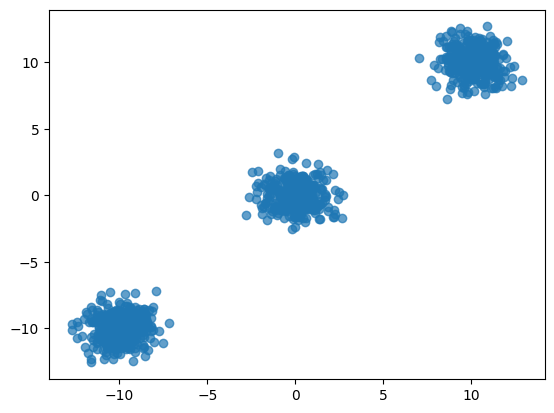

In [4]:
plt.scatter(data[:,0], data[:,1], alpha=0.7)
plt.show()

In [5]:
from mcmc import LangevinDynamics

In [6]:
grad_log_p = jax.jit(jax.grad(mixture.log_p))

n_particles = 100
starter_points = jax.random.normal(key, shape=(n_particles, 1, 2)) * 5
starter_keys = jax.random.split(key, n_particles)

sampler = LangevinDynamics(gradient_func=grad_log_p, n_samples=100, gamma=8e-1)

In [7]:
final_xs, samples = jax.vmap(sampler)(starter_points, starter_keys)

In [8]:
print(samples.shape)
samples = samples.reshape(-1, 2)

(100, 100, 2)


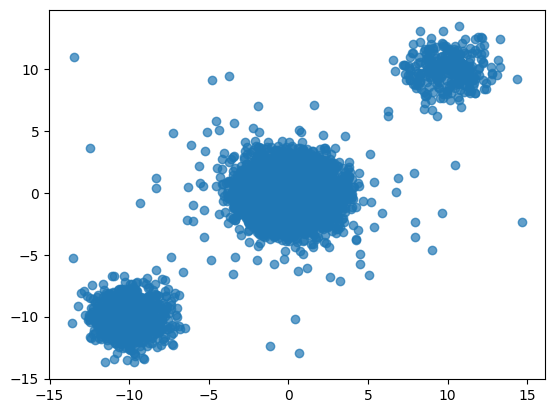

In [9]:
plt.scatter(samples[:,0], samples[:,1], alpha=0.7)
plt.show()

In [10]:
from folx import forward_laplacian

class Generator:
    def __init__(self, grad_log_p, g):
        self.grad_log_p = grad_log_p
        self.fwd_g = forward_laplacian(g)
    
    def __call__(self, x):
        output_g = self.fwd_g(x)
        return np.dot(self.grad_log_p(x), output_g.jacobian.dense_array) + output_g.laplacian

In [11]:
import equinox as eqx
from jax import nn, random

class ControlVariateModel(eqx.Module):
    """Control Variate NN model."""

    mlp: eqx.Module

    def __init__(
        self,
        in_size=1,
        width_size=4096,
        depth=1,
        activation=nn.relu,
        key=random.PRNGKey(45),
    ):
        self.mlp = eqx.nn.MLP(
            in_size=in_size,
            out_size=1,
            width_size=width_size,
            depth=depth,
            activation=activation,
            key=key,
        )

    @eqx.filter_jit
    def __call__(self, x):
        """Forward pass.

        :param x: Data. Should be of shape (1, :),
            as the model is intended to be vmapped over batches of data.
        :returns: Estimated score of a Gaussian.
        """
        return self.mlp(x)
    

cv_model = ControlVariateModel(in_size=2, key=key)
generator = Generator(grad_log_p, cv_model)

In [12]:
generator(np.ones((2), dtype=float))

Array([0.3551779], dtype=float32)

In [ ]:
def control_variate_loss(cv_model: eqx.Module, fn: tp.Callable, batch: np.ndarray) -> float:
    jax.vmap(cv_model)